In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [3]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))])
transform = transforms.Compose([transforms.ToTensor()])
train_set = FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_set = FashionMNIST(root='./data', train=False, download=True, transform=transform)

In [95]:
#5题初始化
def pil_to_numpy(pil_image):
    return np.array(pil_image)
train_set = FashionMNIST(root='./data', train=True, download=True, transform=pil_to_numpy)
test_set = FashionMNIST(root='./data', train=False, download=True, transform=pil_to_numpy)

train_num = 512
test_num = 128
train_loader = DataLoader(train_set, batch_size=train_num, shuffle=True)
test_loader = DataLoader(test_set, batch_size=test_num, shuffle=False)
train_images, train_labels = next(iter(train_loader))
train_images = train_images.numpy()
train_labels = train_labels.numpy()
train_images = train_images.reshape(train_num,784)
train_labels=np.eye(10)[train_labels]
#one-hot
test_images, test_labels = next(iter(test_loader))
test_images = test_images.numpy()
test_labels = test_labels.numpy()
test_images = test_images.reshape(test_num,784)
test_labels.shape, test_images.shape

((128,), (128, 784))

/var/folders/c7/f59bvl4d3nb2tg4_3yk31bqw0000gn/T/ipykernel_33909/2911251569.py:38: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


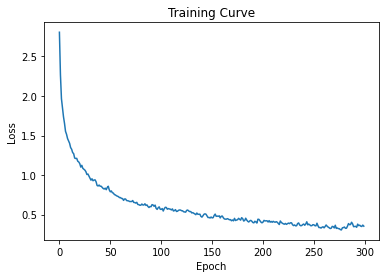

0.75

In [97]:
layer_sizes = [784, 128, 10]
activation_functions = ['sigmoid', 'softmax']
initialization_methods = ['xavier', 'xavier']
learning_rate = 0.1

mlp = MLP(layer_sizes, activation_functions, initialization_methods, learning_rate,0.3,0)
mlp.train(train_images, train_labels, epochs=300)
mlp.plot_training_curve()
predictions = mlp.predict(test_images)
accuracy = calculate_accuracy(test_labels,predictions)
accuracy

In [4]:
import numpy as np

class MLP:
    def __init__(self, layer_sizes, activation_functions, initialization_methods, learning_rate=0.01, lambda_l1=0.0, lambda_l2=0.0, dropout_probs=None):
        assert len(layer_sizes) - 1 == len(activation_functions)
        #每层（除输入层）都需要指定一个激活函数
        self.layer_sizes = layer_sizes
        self.activation_functions = activation_functions
        self.initialization_methods = initialization_methods
        self.learning_rate = learning_rate
        self.weights = []
        self.biases = []
        self.initialize_weights_and_biases()
        self.training_curve = []
        #正则化系数
        if dropout_probs is None:
            self.dropout_probs = [0.] * (len(layer_sizes) - 1)
        else:
            self.dropout_probs = dropout_probs
        self.dropout_masks = []
        #Dropout 概率 
        self.lambda_l1 = lambda_l1
        self.lambda_l2 = lambda_l2
    def initialize_weights_and_biases(self):
        for i in range(len(self.layer_sizes) - 1):
            init_method = self.initialization_methods[i]
            if init_method == "zeros":
                self.weights.append(np.zeros((self.layer_sizes[i], self.layer_sizes[i + 1])))
            elif init_method == "uniform":
                self.weights.append(np.random.uniform(-1, 1, (self.layer_sizes[i], self.layer_sizes[i + 1])))
            elif init_method == "gaussian":
                self.weights.append(np.random.randn(self.layer_sizes[i], self.layer_sizes[i + 1]))
            elif init_method == "xavier":
                self.weights.append(np.random.randn(self.layer_sizes[i], self.layer_sizes[i + 1]) * np.sqrt(2 / (self.layer_sizes[i] + self.layer_sizes[i + 1])))
            elif init_method == "kaiming":
                self.weights.append(np.random.randn(self.layer_sizes[i], self.layer_sizes[i + 1]) * np.sqrt(2. / (self.layer_sizes[i])))
            else:
                raise ValueError(f"Unknown initialization method for layer {i+1}!")
            
            self.biases.append(np.zeros((1, self.layer_sizes[i + 1])))

    def activation(self, z, activation_function):
        if activation_function == 'sigmoid':
            return 1 / (1 + np.exp(-z))
        elif activation_function == 'relu':
            return np.maximum(0, z)
        elif activation_function == 'tanh':
            return np.tanh(z)
        elif activation_function == 'softmax':
            exps = np.exp(z - np.max(z, axis=1, keepdims=True))
            return exps / np.sum(exps, axis=1, keepdims=True)
        else:
            raise ValueError('Unknown activation function: {}'.format(activation_function))

    def derivative_activation(self, a, activation_function):
        if activation_function == 'relu':
            return np.where(a > 0, 1, 0)
        elif activation_function == 'sigmoid':
            return a * (1 - a)
        elif activation_function == 'tanh':
            return 1 - np.square(a)
        else:
            raise ValueError(f"未知的激活函数: {activation_function}")

    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        loss = -np.sum(y_true * np.log(y_pred)) / m
        l1_loss = self.lambda_l1 * np.sum([np.sum(np.abs(w)) for w in self.weights]) / (2 * m)
        l2_loss = self.lambda_l2 * np.sum([np.sum(np.square(w)) for w in self.weights]) / (2 * m)
        total_loss = loss+l1_loss+l2_loss
        return loss

    def forward(self, X, training =  True):
        self.a = [X]
        self.z = []
        self.dropout_masks = [] 
        for i in range(len(self.weights)):
            z = np.dot(self.a[-1], self.weights[i]) + self.biases[i]
            self.z.append(z)
            a = self.activation(z, self.activation_functions[i])
            
            if training and self.dropout_probs[i] > 0:  #在训练时应用dropout
                mask = (np.random.rand(*a.shape) > self.dropout_probs[i]).astype(float) / (1 - self.dropout_probs[i])
                a *= mask
                self.dropout_masks.append(mask)
            else:
                self.dropout_masks.append(np.ones_like(a))
                
            self.a.append(a)
        return a

    def backward(self, X, y):
        m = X.shape[0]
        dz = self.a[-1] - y  # 输出层的 dz
        for i in range(len(self.weights) - 1, -1, -1):
            L = (self.lambda_l1 * np.sign(self.weights[i]) + self.lambda_l2 * self.weights[i]) / m
            dw = np.dot(self.a[i].T, dz) / m
            db = np.sum(dz, axis=0, keepdims=True) / m
            self.weights[i] -= self.learning_rate * dw
            self.biases[i] -= self.learning_rate * db
            if i > 0:
                da = np.dot(dz, self.weights[i].T)
                da *= self.dropout_masks[i-1] 
                dz = da * self.derivative_activation(self.a[i], self.activation_functions[i - 1])

    def train(self, X, y, epochs):
        for _ in range(epochs):
            predictions = self.forward(X,False)
            #防止精度误差
            epsilon = 1e-15
            predictions = np.clip(predictions,epsilon,1-epsilon)
            loss = self.compute_loss(y, predictions)
            self.training_curve.append(loss)
            self.backward(X, y)

    def predict(self, X):
        probabilities = self.forward(X,False)
        predictions = np.argmax(probabilities, axis=1)
        return predictions

    def plot_training_curve(self):
        plt.plot(self.training_curve)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Curve')
        plt.show()

# 假设 X_train 是训练数据, y_train 是 one-hot 编码的标签
# mlp.train(X_train, y_train, epochs=1000)
# predictions = mlp.predict(X_test)  # 假设 X_test 是测试数据


In [5]:
train_num = 512
test_num = 128
train_loader = DataLoader(train_set, batch_size=train_num, shuffle=True)
test_loader = DataLoader(test_set, batch_size=test_num, shuffle=True)
#train
dataiter = iter(train_loader)
#train_images, train_labels = dataiter.next()
train_images, train_labels = next(dataiter)
train_images=train_images.view(train_num,1,784)
train_images=train_images[:,0,:]
train_images=train_images.numpy()
train_labels=train_labels.numpy()

train_labels=np.eye(10)[train_labels]
#test
dataiter = iter(test_loader)
test_images,test_labels = dataiter.next()
test_images=test_images.view(test_num,1,784)
test_images=test_images[:,0,:]
test_images=test_images.numpy()
test_labels=test_labels.numpy()


In [6]:
test_labels.shape, test_images.shape

((128,), (128, 784))

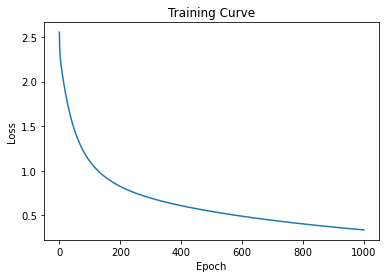

0.75

In [12]:
layer_sizes = [784, 128, 10]
activation_functions = ['sigmoid', 'softmax']
initialization_methods = ['xavier', 'xavier']
learning_rate = 0.1
dropout=[0.3,0.3]
mlp = MLP(layer_sizes, activation_functions, initialization_methods, learning_rate,0.3,0,dropout)
mlp.train(train_images, train_labels, epochs=1000)
mlp.plot_training_curve()
predictions = mlp.predict(test_images)
accuracy = calculate_accuracy(test_labels,predictions)
accuracy

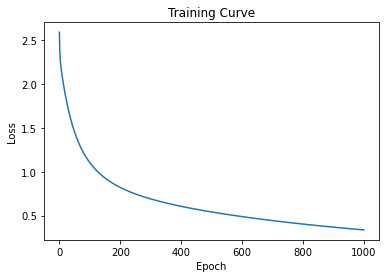

0.7421875

In [10]:
layer_sizes = [784, 128, 10]
activation_functions = ['sigmoid', 'softmax']
initialization_methods = ['xavier', 'xavier']
learning_rate = 0.1
dropout=None
mlp = MLP(layer_sizes, activation_functions, initialization_methods, learning_rate,0.3,0,dropout)
mlp.train(train_images, train_labels, epochs=1000)
mlp.plot_training_curve()
predictions = mlp.predict(test_images)
accuracy = calculate_accuracy(test_labels,predictions)
accuracy

In [8]:
def calculate_accuracy(y_true, y_pred):
    if len(y_true) != len(y_pred):
        raise ValueError("The length of y_true and y_pred must be the same")
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    correct_predictions = np.sum(y_true == y_pred)
    total_predictions = len(y_true)
    
    accuracy = correct_predictions / total_predictions
    
    return accuracy